In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
import logging
from pathlib import Path
import re

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import pandas as pd
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.utils import concat_csv_with_indices

In [7]:
sns.set_context("talk", font_scale=1.5)

In [8]:
L = logging.getLogger(__name__)

In [20]:
dataset = "librispeech-train-clean-100"
state_space_name = "word"

# base_model = "w2v2_8"
# model_class = "rnn_8-weightdecay0.01"
# model_name = "phoneme"

base_model = "w2v2_8"
model_class = "rnn_32-hinge-mAP4"
model_name = "word_broad"

model_dir = f"outputs/models/{dataset}/{base_model}/{model_class}/{model_name}_10frames"
output_dir = f"outputs/notebooks/{dataset}/{base_model}/{model_class}/{model_name}_10frames/word_discrimination"
dataset_path = f"outputs/preprocessed_data/{dataset}"
equivalence_path = f"outputs/equivalence_datasets/{dataset}/{base_model}/{model_name}_10frames/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{dataset}/{base_model}/hidden_states.h5"
state_space_specs_path = f"outputs/state_space_specs/{dataset}/{base_model}/state_space_specs.h5"
embeddings_path = f"outputs/model_embeddings/{dataset}/{base_model}/{model_class}/{model_name}_10frames/{dataset}.npy"

recognition_model = "linear"

In [21]:
state_space_spec = StateSpaceAnalysisSpec.from_hdf5(state_space_specs_path, state_space_name)

In [22]:
dataset_name = Path(dataset_path).name
model_trace = Path(model_dir).relative_to(Path(model_dir).parents[2])

dataset_name, model_trace

('librispeech-train-clean-100',
 PosixPath('w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames'))

In [23]:
predictions_df = concat_csv_with_indices(
    f"outputs/word_recognition/{dataset_name}/{model_trace}/{dataset_name}/{recognition_model}/predictions-frame_*.csv",
    [re.compile(r"frame_(\d+).csv")], ["frame_idx"]) \
        .droplevel(-1).reset_index()
predictions_df["frame_idx"] = predictions_df.frame_idx.astype(int)
predictions_df

,frame_idx,predicted_label_idx,predicted_probability,gt_label_probability,entropy,label_idx,label_instance_idx,example_idx,label,predicted_label,correct
0,9,47,0.702354,0.702354,1.687768,47,0,0,indefinitely,indefinitely,True
1,9,47,0.316576,0.316576,2.927112,47,1,1,indefinitely,indefinitely,True
2,9,47,0.465954,0.465954,2.353336,47,2,2,indefinitely,indefinitely,True
3,9,47,0.452813,0.452813,2.604070,47,3,3,indefinitely,indefinitely,True
4,9,47,0.273758,0.273758,3.326951,47,4,4,indefinitely,indefinitely,True
...,...,...,...,...,...,...,...,...,...,...,...
1408132,3,19221,0.811361,0.054920,1.083792,19997,3,213105,carlyle's,carlyle,False
1408133,3,19221,0.333439,0.038692,2.777267,19997,4,213106,carlyle's,carlyle,False
1408134,3,19221,0.543694,0.086332,2.238341,19997,5,213107,carlyle's,carlyle,False
1408135,3,19998,0.373479,0.373479,2.677208,19998,0,213108,tagrag,tagrag,True


In [24]:
chance_performance = predictions_df.groupby("frame_idx") \
    .apply(lambda x: x.label.value_counts(normalize=True).max()).rename("chance_performance")
chance_performance

/tmp/ipykernel_279147/145781247.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.label.value_counts(normalize=True).max()).rename("chance_performance")


frame_idx
0     0.000195
1     0.000195
2     0.000201
3     0.000235
4     0.000305
5     0.000441
6     0.000697
7     0.001190
8     0.002205
9     0.004538
10    0.009673
11    0.024190
12    0.068027
13    0.126506
14    0.346154
15    0.666667
Name: chance_performance, dtype: float64

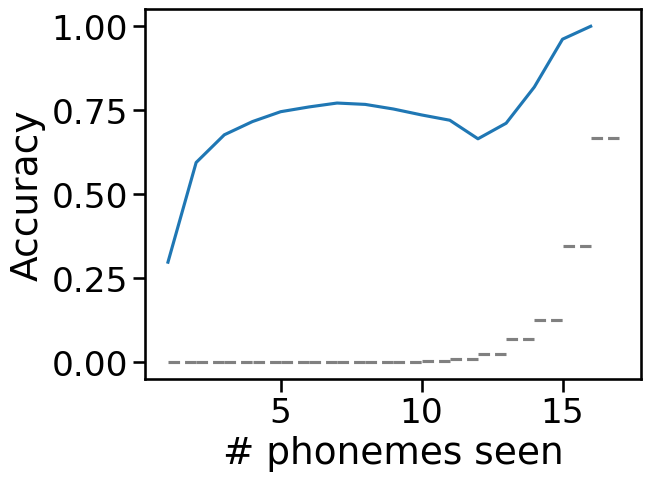

In [25]:
acc_df = predictions_df.groupby("frame_idx").correct.mean().reset_index()
acc_df["num_frames"] = acc_df.frame_idx + 1
acc_df.to_csv(Path(output_dir) / "accuracy.csv", index=False)
ax = sns.lineplot(data=acc_df, x="num_frames", y="correct")

ax.set_xlabel("# phonemes seen")
ax.set_ylabel("Accuracy")

# draw chance performance as a horizontal line over each x value
for frame, frame_chance_perf in chance_performance.items():
    ax.plot([frame + 1, frame + 2], [frame_chance_perf, frame_chance_perf],
            color="gray", linestyle="--")

## Confusion matrix

In [38]:
confusion_df = predictions_df.loc[predictions_df.label != predictions_df.predicted_label]
confusion_df["confusion"] = confusion_df.label + " -> " + confusion_df.predicted_label
confusion_df = confusion_df.groupby("frame_idx").confusion.value_counts(normalize=True)

/tmp/ipykernel_279147/2032620870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confusion_df["confusion"] = confusion_df.label + " -> " + confusion_df.predicted_label


In [39]:
# DEV
confusion_df = confusion_df.to_frame().reset_index()
confusion_df[["label", "predicted_label"]] = confusion_df.confusion.str.split(" -> ", expand=True)

In [42]:
# DEV
confusion_df["ok"] = (confusion_df.label == confusion_df.predicted_label + "s") | (confusion_df.label + "s" == confusion_df.predicted_label)

In [45]:
inspect_df = confusion_df[~confusion_df.ok].sort_values("proportion", ascending=False).set_index("frame_idx").sort_index()
inspect_df

,confusion,proportion,label,predicted_label,ok
frame_idx,,,,,
0,reproachfully -> retire,0.000006,reproachfully,retire,False
0,hordes -> hook,0.000006,hordes,hook,False
0,hordes -> horror,0.000006,hordes,horror,False
0,hordes -> horse,0.000006,hordes,horse,False
0,horizon -> ardan,0.000006,horizon,ardan,False
...,...,...,...,...,...
13,respectability -> responsibility,0.033333,respectability,responsibility,False
13,representations -> representatives,0.033333,representations,representatives,False
13,misinterpretation -> incomprehensible,0.033333,misinterpretation,incomprehensible,False


In [56]:
inspect_df.loc[10].head(30)

,confusion,proportion,label,predicted_label,ok
frame_idx,,,,,
10,protestants -> propositions,0.000692,protestants,propositions,False
10,anticipated -> necessitated,0.000692,anticipated,necessitated,False
10,antecedents -> disobedience,0.000692,antecedents,disobedience,False
10,accumulations -> humiliating,0.000692,accumulations,humiliating,False
10,ramifications -> mortification,0.000692,ramifications,mortification,False
10,anticipated -> substituted,0.000692,anticipated,substituted,False
10,accumulation -> continually,0.000692,accumulation,continually,False
10,accompaniment -> compliments,0.000692,accompaniment,compliments,False
10,recalcitrant -> characteristics,0.000692,recalcitrant,characteristics,False


In [12]:
for frame_idx, frame_confusions in confusion_df.groupby("frame_idx"):
    print(frame_idx)
    print(frame_confusions.sort_values(ascending=False).head(40))

# honor honour
# favor favour
# favorite favourite
# neighborhood neighbourhood
# labor labour
# center centre
# recognised recognized
# travelling traveling
# parlor parlour
# colored coloured
# neighbors neighbours
# favourable favorable
# favourably favorably

# thro??

0
frame_idx  confusion                    
0          isabel -> isabella               0.000205
           afterwards -> afterward          0.000178
           ideas -> idea                    0.000172
           useful -> useless                0.000155
           eighteen -> eighty               0.000144
           animal -> animals                0.000133
           thousands -> thousand            0.000133
           honor -> honour                  0.000128
           sufficiently -> sufficient       0.000128
           affairs -> affair                0.000122
           cannot -> can                    0.000122
           efforts -> effort                0.000122
           taken -> take                    0.000122
           pass -> passed                   0.000117
           voice -> voices                  0.000117
           saved -> save                    0.000117
           soon -> sooner                   0.000117
           keeping -> keep                  0.000117
   

In [ ]:
confusion_df.sample(20).reset_index().sort_values('frame_idx')

In [ ]:
predictions_df[~predictions_df.correct] \
    .groupby("frame_idx", as_index=False)[["frame_idx", "label", "predicted_label"]].sample(40, replace=True) \
    .sort_values("frame_idx") \
    .to_csv(Path(output_dir) / "confusions.csv", index=False)

## Time-course of identification

In [ ]:
study_labels = np.random.choice(predictions_df.label.unique(), 16, replace=False)
num_cols = 2
num_rows = int(np.ceil(len(study_labels) / num_cols))
f, axs = plt.subplots(num_rows, num_cols, figsize=(26, 8 * num_rows))
plt.subplots_adjust(hspace=0.5)
word_font_size = plt.rcParams["font.size"] * 0.8

for ax, label in zip(tqdm(axs.flat), study_labels):
    label_rows = predictions_df.loc[predictions_df.label == label]
    instance_trajs = [instance_rows.correct.values for _, instance_rows in label_rows.groupby("label_instance_idx")]
    instance_predictions = [instance_rows.predicted_label.values for _, instance_rows in label_rows.groupby("label_instance_idx")]
    # pad
    max_len = max(len(traj) for traj in instance_trajs)
    instance_trajs = np.array([np.pad(traj, (0, max_len - len(traj))) for traj in instance_trajs])

    ax.axhline(0.5, color="gray", linestyle="--", alpha=0.5)

    # plot words at transitions from correct to incorrect
    frame_prediction_changes = (np.diff(instance_trajs.astype(int), axis=1) == -1).nonzero()
    for instance_iloc, frame_idx in zip(*frame_prediction_changes):
        if frame_idx + 1 < len(instance_predictions[instance_iloc]):
            ax.text(frame_idx + 2, 0 + np.random.random() * 0.2 - 0.1,
                    instance_predictions[instance_iloc][frame_idx + 1],
                    color="red", ha="center", size=word_font_size)

    # plot initial mistakes
    initial_mistakes = (instance_trajs[:, 0] == 0).nonzero()[0]
    initial_mistakes_y = np.linspace(-0.3, 0.7, len(initial_mistakes))
    for instance_iloc, text_y in zip(initial_mistakes, initial_mistakes_y):
        ax.text(1 - 0.15, text_y,
                instance_predictions[instance_iloc][0],
                color="red", ha="left", size=word_font_size)

    ax.set_title(label)
    ax.plot(list(range(1, max_len + 1)), instance_trajs.T + np.random.random((1, instance_trajs.shape[0])) * 0.1, alpha=0.5)
    ax.plot(list(range(1, max_len + 1)), instance_trajs.mean(axis=0), color="black", linewidth=4)

    ax.set_xlabel("# phonemes seen")
    ax.set_xticks(list(range(1, max_len + 1)))
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Incorrect", "Correct"])

f.savefig(Path(output_dir) / "prediction_time_courses.pdf", bbox_inches="tight")

## Lexical effects in recognition time course

### Frequency

In [ ]:
word_freq_df = pd.read_csv("data/SUBTLEXus74286wordstextversion.txt", sep="\t", index_col=0)
num_frequency_bins = 6
word_freq_df["log_frequency_bin"] = pd.qcut(word_freq_df.Lg10WF, num_frequency_bins, duplicates="drop")
word_frequency_bins = word_freq_df.log_frequency_bin.cat.categories
word_freq_df["log_frequency_bin"] = word_freq_df["log_frequency_bin"].cat.codes

In [ ]:
word_frequency_bins

In [ ]:
predictions_df_meta = pd.merge(predictions_df, word_freq_df, left_on="label", right_index=True)
predictions_df_meta["# phonemes seen"] = predictions_df_meta.frame_idx + 1

In [ ]:
ax = sns.lineplot(data=predictions_df_meta,
             x="# phonemes seen", y="correct", hue="log_frequency_bin", palette="viridis")
ax.legend(title="Word frequency bin", loc="upper left", bbox_to_anchor=(1, 1))


In [ ]:
# performance on words in each frequency bin
predictions_df_meta \
    .groupby(["log_frequency_bin", "label", "label_instance_idx"]).correct.max() \
    .groupby(["log_frequency_bin", "label"]).filter(lambda x: len(x) > 10) \
    .groupby(["log_frequency_bin", "label"]).mean() \
    .groupby("log_frequency_bin").mean()

In [ ]:
# top-predicted words per frequency bin
predictions_df_meta \
    .groupby("label").filter(lambda x: len(x) > 10) \
    .groupby(["log_frequency_bin", "label", "label_instance_idx"]).correct.max() \
    .groupby(["log_frequency_bin", "label"]).mean().sort_values() \
    .groupby("log_frequency_bin").tail(10)

In [ ]:
# sample of prediction performance per frequency bin
predictions_df_meta \
    .groupby("label").filter(lambda x: len(x) > 10) \
    .groupby(["log_frequency_bin", "label", "label_instance_idx"]).correct.max() \
    .groupby(["log_frequency_bin", "label"]).mean().sort_values() \
    .groupby("log_frequency_bin").sample(10)

### Cohort size

In [ ]:
# We don't save the actual training set which is a subsample of the full state space spec.
# We thus won't be able to get item-level stats on cohort of a particular word pronunciation.
# But we can get the expected / marginal case.

In [ ]:
dev_df = state_space_spec.cuts.xs("phoneme", level="level").reset_index()
dev_df["phoneme_idx"] = dev_df.groupby(["label", "instance_idx"]).cumcount()

In [ ]:
# reset temporary tables
duckdb.query("DROP TABLE IF EXISTS phoneme_sequences; DROP TABLE IF EXISTS cohorts;")

# get a table of cohort sizes
cohorts = duckdb.query("""
    -- Step 1: Create a temporary table with concatenated descriptions and their lengths
    CREATE TEMPORARY TABLE phoneme_sequences AS
    SELECT 
        label, 
        instance_idx, 
        STRING_AGG(description, ' ' ORDER BY phoneme_idx) AS phoneme_seq,
        LENGTH(STRING_AGG(description, ' ')) - LENGTH(REPLACE(STRING_AGG(description, ' '), ' ', '')) + 1 AS phoneme_count
    FROM dev_df
    GROUP BY label, instance_idx;

    -- Step 2: Create cohorts table
    CREATE TEMPORARY TABLE cohorts AS
    WITH recursive cohorts_cte AS (
        SELECT 
            label,
            instance_idx,
            phoneme_seq,
            SPLIT_PART(phoneme_seq, ' ', 1) AS prefix,
            phoneme_count,
            1 AS prefix_length
        FROM phoneme_sequences
        UNION ALL
        SELECT 
            label,
            instance_idx,
            phoneme_seq,
            TRIM(prefix || ' ' || REGEXP_EXTRACT(SUBSTRING(phoneme_seq FROM LENGTH(prefix) + 2), '^[^ ]+')) AS prefix,
            phoneme_count,
            prefix_length + 1
        FROM cohorts_cte
        WHERE prefix_length < phoneme_count
    )
    SELECT 
        prefix AS phoneme_prefix,
        label,
        COUNT(*) AS count
    FROM cohorts_cte
    GROUP BY phoneme_prefix, label;
             
    SELECT * FROM cohorts;
    """).to_df().set_index(["phoneme_prefix", "label"]).sort_index()

cohorts

In [ ]:
duckdb.query("DROP TABLE IF EXISTS phoneme_sequences; DROP TABLE IF EXISTS cohorts;")
articulation_df = duckdb.query("""
    -- Step 1: Create a temporary table with concatenated descriptions and their lengths
    CREATE TEMPORARY TABLE phoneme_sequences AS
    SELECT
        label,
        phoneme_seq,
        COUNT(*) AS count
    FROM (
        SELECT label, 
            instance_idx, 
            STRING_AGG(description, ' ' ORDER BY phoneme_idx) AS phoneme_seq,
            LENGTH(STRING_AGG(description, ' ')) - LENGTH(REPLACE(STRING_AGG(description, ' '), ' ', '')) + 1 AS phoneme_count
        FROM dev_df
        GROUP BY label, instance_idx)
    GROUP BY label, phoneme_seq;
             
    SELECT label, phoneme_seq, count / SUM(count) OVER (PARTITION BY label) AS proportion
    FROM phoneme_sequences;""").to_df().dropna()
articulation_df

In [ ]:
prefix2idx = {prefix: idx for idx, prefix in enumerate(sorted(cohorts.index.get_level_values("phoneme_prefix").unique()))}
idx2prefix = {idx: prefix for prefix, idx in prefix2idx.items()}
idx2word = sorted(articulation_df.label.unique())
word2idx = {word: idx for idx, word in enumerate(idx2word)}

prefix_mat = sp.dok_matrix((len(word2idx), len(prefix2idx)))

for _, row in articulation_df.iterrows():
    phoneme_seq = row.phoneme_seq.split(" ")
    for prefix_length in range(1, len(phoneme_seq) + 1):
        prefix_mat[word2idx[row.label], prefix2idx[" ".join(phoneme_seq[:prefix_length])]] += row.proportion

prefix_mat = prefix_mat.tocsr()

In [ ]:
cohort_sizes = prefix_mat.sum(axis=0).A1
cohort_entropies = -(prefix_mat / prefix_mat.sum(axis=0)).multiply((prefix_mat / prefix_mat.sum(axis=0)).log1p()).sum(axis=0).A1
cohort_entropies[np.isnan(cohort_entropies)] = 0

In [ ]:
[idx2prefix[idx] for idx in (-cohort_sizes).argsort()[:5]]

In [ ]:
# construct masks for each frame idx
frame_idx_masks = np.stack([np.array([1 if prefix.count(" ") == frame_idx else 0 for prefix in idx2prefix.values()]) for frame_idx in range(10)]).T
frame_idx_masks.shape

incremental_cohort_sizes = prefix_mat.multiply(cohort_sizes).dot(frame_idx_masks)
incremental_cohort_entropies = prefix_mat.multiply(cohort_entropies).dot(frame_idx_masks)

articulation_df["num_phonemes"] = articulation_df.phoneme_seq.str.count(" ") + 1
word_max_lengths = articulation_df.groupby("label").num_phonemes.max()

# Create a mask on the derived cohort stats for phonemes never attested
attested_mask = np.zeros_like(incremental_cohort_sizes, dtype=bool)
for word, max_length in word_max_lengths.items():
    attested_mask[word2idx[word], max_length:] = True

incremental_cohort_sizes[attested_mask] = np.nan
incremental_cohort_entropies[attested_mask] = np.nan

In [ ]:
cohort_size_df = pd.DataFrame(incremental_cohort_sizes, index=pd.Index(idx2word, name="label")).reset_index().melt(id_vars=["label"], var_name="frame_idx", value_name="cohort_size")
cohort_entropy_df = pd.DataFrame(incremental_cohort_entropies, index=pd.Index(idx2word, name="label")).reset_index().melt(id_vars=["label"], var_name="frame_idx", value_name="cohort_entropy")
cohort_meta_df = pd.merge(cohort_size_df, cohort_entropy_df)
cohort_meta_df = cohort_meta_df.dropna()

cohort_meta_df["cohort_size_bin"] = pd.qcut(cohort_meta_df.cohort_size, 5, duplicates="drop")
cohort_meta_df["cohort_size_bin"] = cohort_meta_df.cohort_size_bin.cat.codes.astype(str)
cohort_meta_df["cohort_entropy_bin"] = pd.qcut(cohort_meta_df.cohort_entropy, 5, duplicates="drop")
cohort_meta_df["cohort_entropy_bin"] = cohort_meta_df.cohort_entropy_bin.cat.codes.astype(str)
cohort_meta_df

In [ ]:
predictions_df_meta = pd.merge(predictions_df, cohort_meta_df, on=["label", "frame_idx"], how="left")
predictions_df_meta["# phonemes seen"] = predictions_df_meta.frame_idx + 1

In [ ]:
ax = sns.lineplot(data=predictions_df_meta, x="# phonemes seen", y="correct", hue="cohort_size_bin", hue_order=sorted(cohort_meta_df.cohort_size_bin.unique()),
                  palette="viridis")
ax.legend(title="Cohort size bin", loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xticks(list(range(1, 11)))

In [ ]:
sns.lineplot(data=predictions_df_meta, x="frame_idx", y="correct", hue="cohort_entropy_bin", hue_order=sorted(cohort_meta_df.cohort_entropy_bin.unique()),
             palette="viridis")

### Neighborhood density

In [ ]:
aelp_df = pd.read_csv("data/aelp.csv", index_col=0)

aelp_df["phono_dens_bin"] = pd.qcut(aelp_df.phono_n_dens_s, 5, duplicates="drop")
print(aelp_df.phono_dens_bin.cat.categories)
aelp_df["phono_dens_bin"] = aelp_df.phono_dens_bin.cat.codes
aelp_df

In [ ]:
aelp_df_merged = pd.merge(predictions_df_meta, aelp_df, left_on="label", right_index=True)

In [ ]:
aelp_df_merged.groupby("phono_dens_bin").sample(5)[["label", "phono_dens_bin", "phono_n_dens_s"]]

In [ ]:
sns.lineplot(data=aelp_df_merged, x="frame_idx", y="correct", hue="phono_dens_bin")

## Recognition point analysis (intrinsic/probabilistic)

In [ ]:
recognition_intrinsic_threshold = 0.6
predictions_df["recognized"] = predictions_df.predicted_probability >= recognition_intrinsic_threshold
predictions_df["recognized_gt"] = predictions_df.correct & (predictions_df.predicted_probability >= recognition_intrinsic_threshold)

recognition_criteria = ["recognized", "recognized_gt"]
# intrinsic_recognition_points = predictions_df.groupby(["label", "label_instance_idx"]).apply(
#     lambda xs: pd.Series(xs[recognition_measures].values.argmax(0) * xs[recognition_measures].any(axis=0).map({True: 1, False: np.nan}).values, index=recognition_measures))

In [ ]:
# get first frame within label, label_instance_idx where recognition is achieved under recognized_gt measure
recognition_point_df = pd.concat({
    criterion_name: duckdb.query(f"""
            SELECT label, label_instance_idx, MIN(frame_idx) AS frame_idx
            FROM predictions_df
            WHERE {criterion_name}
            GROUP BY label, label_instance_idx;
        """).to_df().set_index(["label", "label_instance_idx"]).rename(columns={"frame_idx": "recognition_point"})
    for criterion_name in recognition_criteria
}, names=["criterion"]).unstack("criterion").sort_index()
recognition_point_df.columns = recognition_point_df.columns.droplevel(0)
recognition_point_df.columns = [f"{criterion}_point" for criterion in recognition_point_df.columns]
recognition_point_df

In [ ]:
sns.displot(data=recognition_point_df.reset_index().melt(id_vars=["label", "label_instance_idx"]), x="value", col="variable", discrete=True)

In [ ]:
# add AELP metadata
aelp_vars = ["phono_n_dens_s", "phono_n_freq_s_m", "phono_upoint",
             "lgsubtlwf", "n_phon", "sum_biphone"]
recognition_point_df = pd.merge(recognition_point_df.reset_index(), aelp_df, left_on="label", right_on="word_us")[["label", "label_instance_idx"] + aelp_vars + [f"{x}_point" for x in recognition_criteria]].reset_index()
recognition_point_df.to_csv(f"{output_dir}/recognition_points.csv", index=False)


In [ ]:
plot_data = recognition_point_df[aelp_vars + ["recognized_gt_point"]].reset_index().melt(id_vars=["index", "recognized_gt_point"])
plot_data = plot_data[~plot_data.recognized_gt_point.isna()]
if len(plot_data) == 0:
    print("Nothing to plot. Stop.")
else:
    # jitter
    plot_data["value_jitter"] = plot_data.value + np.random.normal(0, 0.05, len(plot_data))
    plot_data["recognition_point_jitter"] = plot_data.recognized_gt_point + np.random.normal(0, 0.05, len(plot_data))
    g = sns.relplot(data=plot_data,
                    x="recognition_point_jitter", y="value_jitter", col="variable", col_wrap=2,
                    kind="scatter", facet_kws=dict(sharey=False))

    for hue, ax in g.axes_dict.items():
        # line of best fit
        sns.lineplot(data=plot_data[plot_data.variable == hue],
                    x="recognized_gt_point", y="value", ax=ax, color="black")

## Recognition point analysis (extrinsic)

In [ ]:
recognition_threshold = 0.7
recognition_count_threshold = 10

recognition_df = predictions_df \
    .groupby("label").filter(lambda xs: len(xs) >= recognition_count_threshold) \
    .groupby(["label", "frame_idx"]).correct.mean() > recognition_threshold
# filter out words which never pass threshold
# then compute first frame at which we pass threshold
recognition_points = recognition_df.groupby("label").filter(lambda x: x.any()) \
    .groupby("label").idxmax().str[1].rename("recognition_point")

sns.boxenplot(recognition_points)

In [ ]:
plot_vars = ["phono_n_dens_s", "phono_n_freq_s_m", "phono_upoint",
            "lgsubtlwf", "n_phon", "sum_biphone"]
plot_data = pd.merge(recognition_points, aelp_df, left_index=True, right_index=True)[plot_vars + ["recognition_point"]].reset_index().melt(id_vars=["index", "recognition_point"])
if len(plot_data) == 0:
    print("Nothing to plot. Stop.")
else:
    # jitter
    plot_data["value_jitter"] = plot_data.value + np.random.normal(0, 0.05, len(plot_data))
    plot_data["recognition_point_jitter"] = plot_data.recognition_point + np.random.normal(0, 0.05, len(plot_data))
    g = sns.relplot(data=plot_data,
                    x="recognition_point_jitter", y="value_jitter", col="variable", col_wrap=2,
                    kind="scatter", facet_kws=dict(sharey=False))

    for hue, ax in g.axes_dict.items():
        # line of best fit
        sns.lineplot(data=plot_data[plot_data.variable == hue],
                    x="recognition_point", y="value", ax=ax, color="black")

In [ ]:
recognition_points.drop(columns=["value_jitter", "recognition_point_jitter"]) \
    .to_csv(Path(output_dir) / f"recognition_points-threshold{recognition_threshold}.csv")